In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap
from sklearn.decomposition import PCA # Principal Component Analysis
from statsmodels.tsa.vector_ar.var_model import VAR # Vector Auto Regressive model
from statsmodels.tsa.stattools import (
    adfuller, 
    kpss, 
    ) # Homoscedasticity 



pd.set_option('display.max_columns', 40)
plt.rcParams.update({'axes.grid': True, 'grid.alpha': .33})


df: pd.DataFrame = pd.read_csv("Life Expectancy Data.csv")


# Format DataFrame for further analysis
stripped_columns = []

for col_num, col_name in enumerate(df.columns):
    stripped_columns.append(col_name.strip(' '))
    
df.columns = stripped_columns

# Failsafe DataFrame in case we duck up something
df = df.sort_values(by=['Country', 'Year'])
df = df.reset_index(drop=True)


# Dictionary with countries as keys and corresponding DataFrame slices as values
df_per_country = {country: df for country, df in df.groupby('Country')}

**<h4>**Handling outliers**<h4>**

In [154]:
# Replace values beyond IQR with median
for country, country_df in df_per_country.items():
    for column in country_df.columns[4:]:

        descriptive_stats = country_df[column].describe()


        median = descriptive_stats['50%']
        Q1 = descriptive_stats['25%']
        Q3 = descriptive_stats['75%']
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        upper_condition = (country_df[column] > upper_bound)
        lower_condition = (country_df[column] < lower_bound)

        combined_boolean_indexing = (upper_condition | lower_condition)
        
        country_df.loc[combined_boolean_indexing, column] = median

        


C:\Users\user\AppData\Local\Temp\ipykernel_18944\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_df.loc[combined_boolean_indexing, column] = median
C:\Users\user\AppData\Local\Temp\ipykernel_18944\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_df.loc[combined_boolean_indexing, column] = median
C:\Users\user\AppData\Local\Temp\ipykernel_18944\1032146720.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '109.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  country_

In [182]:
# Restoring DataFrame to its original shape
df = pd.concat(df_per_country.values())

**<h2>**Handling missing data**</h2>**
**<h4>**For every column that contains NULL values we look for the indexes of missing values in order to understand the nature of the absence**<h4>**

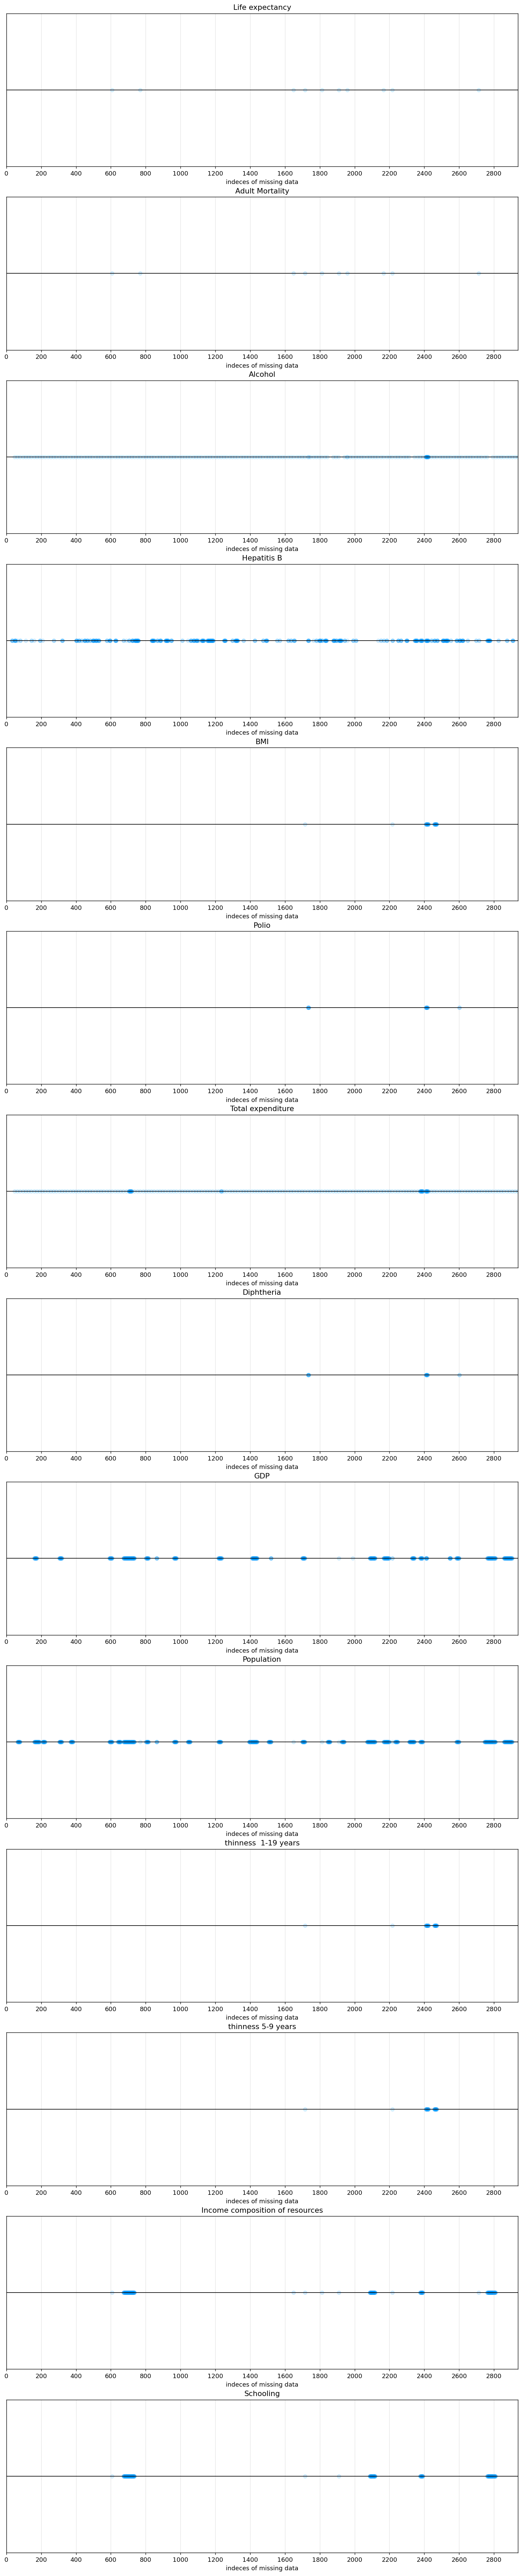

In [183]:
columns_with_null_values = df.columns[(df.isnull().sum()>0).values]
column_and_indeces = {}

for column in columns_with_null_values:
    column_and_indeces[column] = df[df[column].isnull()==True].index

fig, axes = plt.subplots(len(column_and_indeces), figsize = (15, 75), dpi = 130)
xmin = 0
xmax = len(df)


for index, (key, values) in enumerate(column_and_indeces.items()):
    axes[index].hlines(y=0, xmin=xmin, xmax=xmax, color='black', linewidth=1)

    axes[index].scatter(values, [0] * len(values), color=(0,0.6,1), alpha=0.15)

    axes[index].set_yticks([])
    axes[index].set_xticks(np.arange(xmin, xmax, 200))

    axes[index].set_xlim(0, 2938)
    axes[index].set_ylim(-1, 1)

    axes[index].set_title(key)
    axes[index].set_xlabel('indeces of missing data')

**<h4>**We can see that for certain columns the reason behind missing data is not completely random (Alcohol, BMI, Diphteria and so on.)**</h4>**

**<h5>**This is not good, because we cannot really drop rows with null values as we're going to lose insane amount of data, and standard techniques such as filling Null values with median/mean of corresponding column will not be quite statistically accurate**</h5>**

**<h5>**Thus, I tried impementing another way of handling missing data**</h5>**
<br><br>
**<h3>**That's an experimental method to fill in NA values so I don't really count on its theorethical foundation**<h3>**

In [157]:
from numpy.linalg import norm
from numpy import dot 



# Define cosine similarity function
def cosine_similarity(a: tuple | list,b: tuple | list) -> np.float64:

    return dot(a,b) / (norm(a) * norm(b))


# Leaving only rows with NULL values in DataFrame 
non_null_indexes = df.dropna().index
null_indexes = []

for index in df.index:
    if index not in non_null_indexes:
        null_indexes.append(index)


# DataFrame without null values
df_wo_null_values = df.copy()
df_wo_null_values = df_wo_null_values.dropna()
df_wo_null_values = df_wo_null_values.reset_index(drop=True)

# DataFrame with null values
df_with_null_values = df.copy()
df_with_null_values = df_with_null_values.iloc[null_indexes, :]
df_with_null_values = df_with_null_values.reset_index(drop=True)

for row_num, row in df_with_null_values.iterrows():

    columns_with_null_values = row[row.isnull()].index

    feature_vector = tuple(row.fillna(0).values)[3:]

    similarities = []

    for row_num_2, row_2 in df_wo_null_values.iterrows():

        feature_vector_2 = row_2.copy()
        feature_vector_2[columns_with_null_values] = 0
        feature_vector_2 = tuple(feature_vector_2.values)[3:]

        similarity = cosine_similarity(feature_vector, feature_vector_2)

        row_similarity = {row_num_2: similarity}
        similarities.append(row_similarity)
    

    
    series = pd.Series(similarities).apply(lambda x: list(x.values())[0])
    most_similar_rows = series.sort_values(ascending=False)[:100]
    most_similar_rows_indexes = most_similar_rows.index

    median_values = df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values].median()
    mad = (df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values] - df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values].mean()).abs().mean() 
    normally_distributed_value = np.random.normal(loc=0, scale=1, size=1)[0]

    values_to_fill = median_values + mad * normally_distributed_value
    df_with_null_values.loc[row_num, columns_with_null_values] = values_to_fill

In [188]:
# Save result as it takes way too much to run the algorithm above
df = pd.concat([df_wo_null_values, df_with_null_values]).reset_index(drop=True).sort_values(by=['Country', 'Year'])
df.to_csv('restored_df.csv')

In [189]:
cleaned_df = pd.read_csv('restored_df.csv')
cleaned_df = cleaned_df.drop('Unnamed: 0', axis=1)

**<h3>**Let's redo the procedure of handling outliers**<h3>**

In [190]:
df_per_country = {country: df for country, df in cleaned_df.groupby('Country')}

# Replace values beyond IQR with median
for country, country_df in df_per_country.items():
    for column in country_df.columns[4:]:

        descriptive_stats = country_df[column].describe()


        median = descriptive_stats['50%']
        Q1 = descriptive_stats['25%']
        Q3 = descriptive_stats['75%']
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        upper_condition = (country_df[column] > upper_bound)
        lower_condition = (country_df[column] < lower_bound)

        combined_boolean_indexing = (upper_condition | lower_condition)
        
        country_df.loc[combined_boolean_indexing, column] = median

        
# Restoring DataFrame to its original shape
cleaned_df = pd.concat(df_per_country.values())

**<h3>**Now as we have cleaned DataFrame without significat outliers, we can break this task into 2:**</h3>**

**<h4>**1) Regression Analysis for each year<br>2) Time Series Analysis for each country**</h4>**


**<h5>**NOTE: We can justify looking at the problem from regression point of view analysis the bare minimum condition of having atleast 5-6 training example per feature is satisfied**</h5>**


In [191]:
regression_df = cleaned_df.copy()
regression_df = regression_df.sort_values(by='Year')
regression_df = regression_df.reset_index(drop=True)

regression_df['Status'] = regression_df['Status'].replace({
    "Developed": 1,
    "Developing": 0,
})


C:\Users\user\AppData\Local\Temp\ipykernel_18944\991126393.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  regression_df['Status'] = regression_df['Status'].replace({


**<h3>**Let us investigate the feature space on correlations in order to have our model build on a correct dataset that will not result in statistically insignificant results**</h3>**

<Axes: >

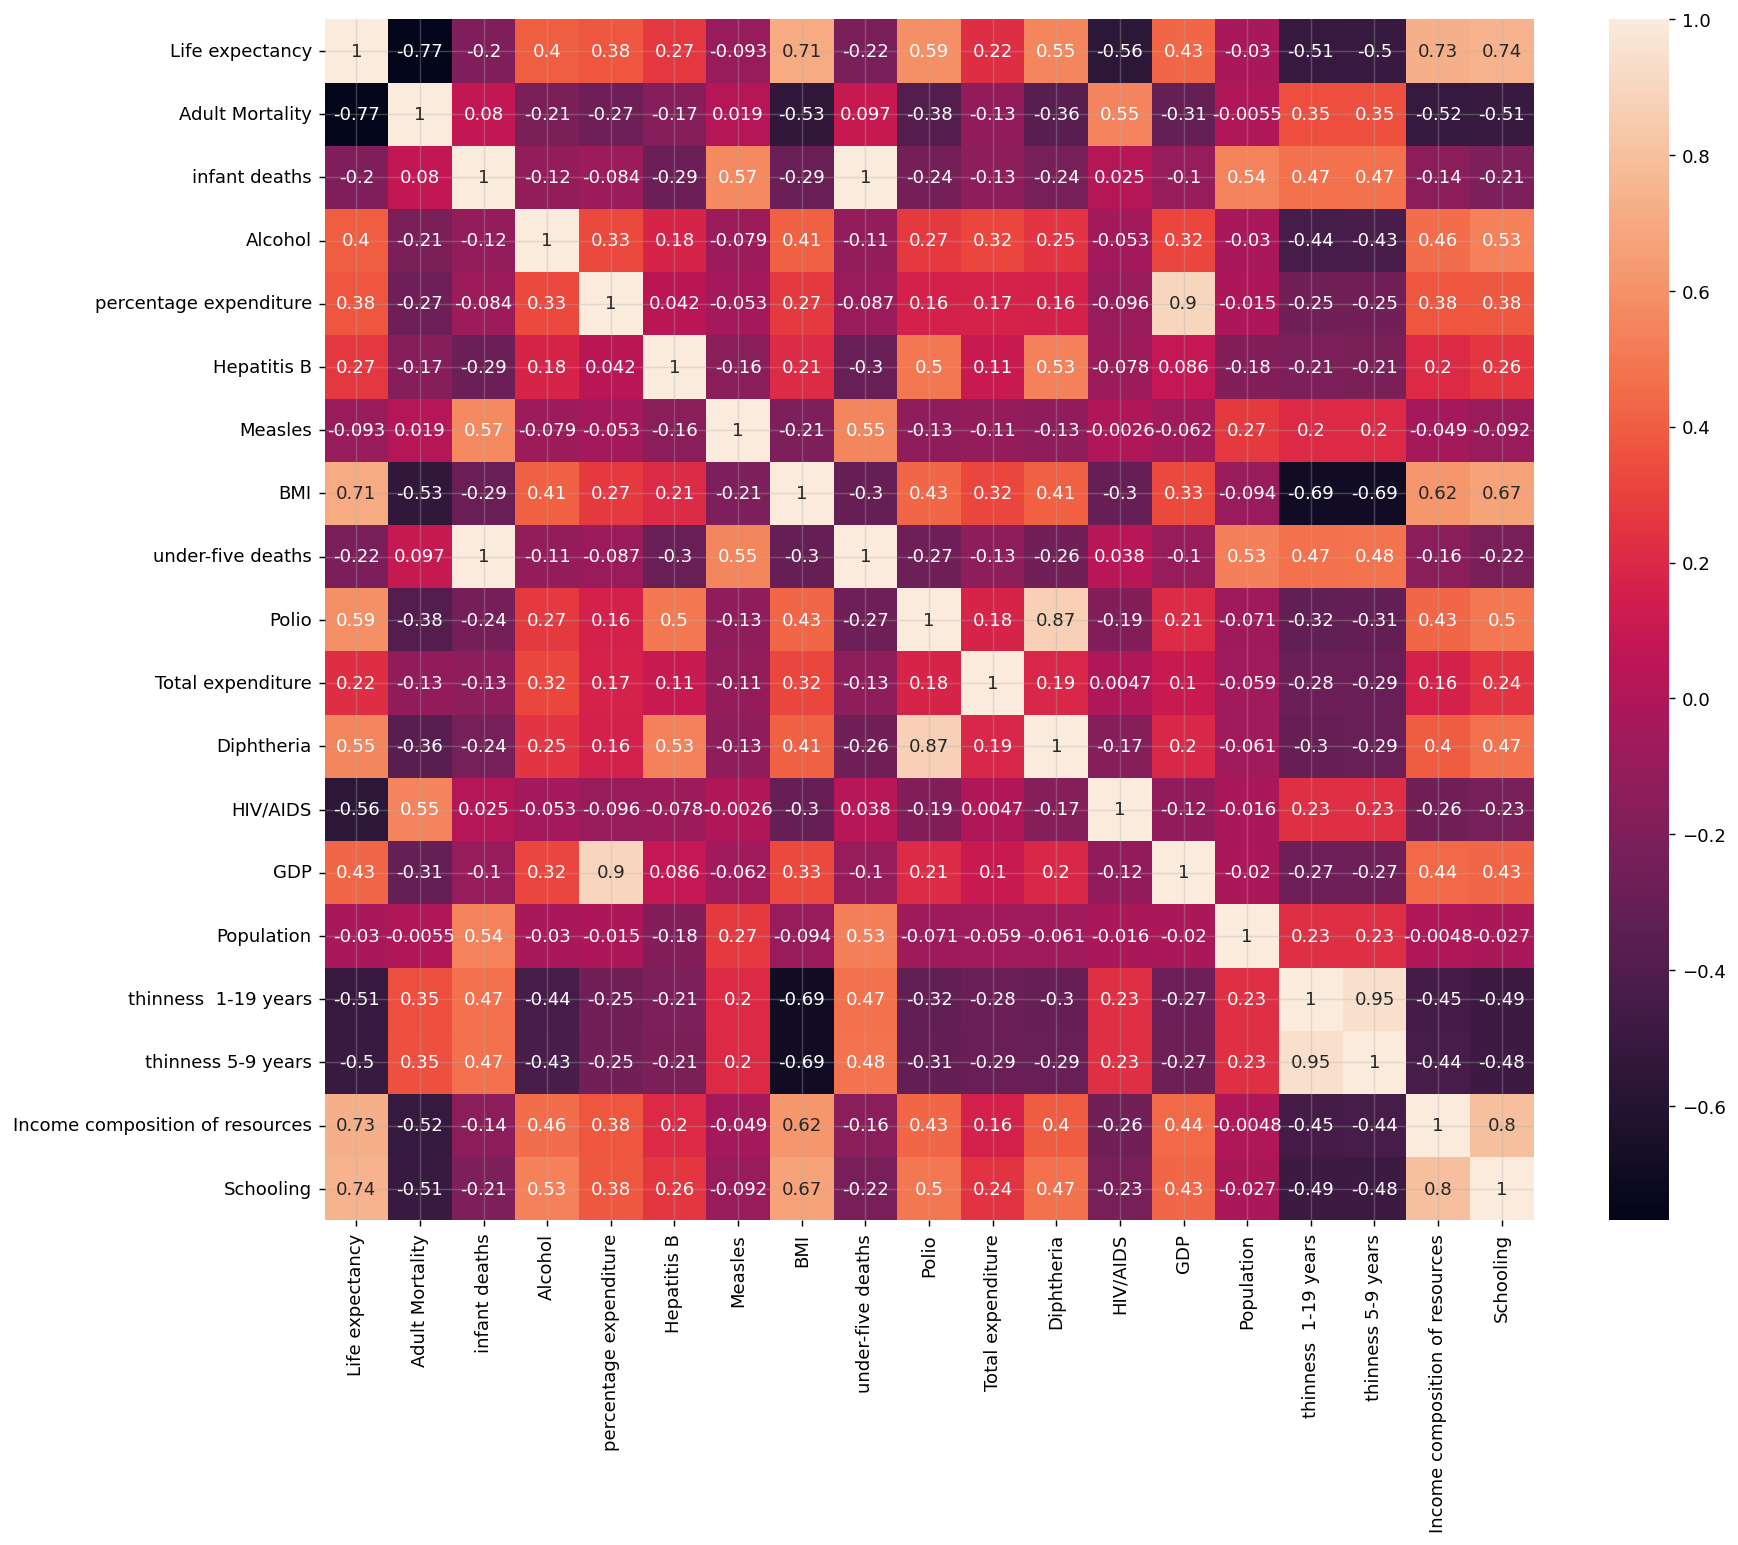

In [193]:
fig, ax = plt.subplots(figsize = (15,12), dpi=130)


heatmap(regression_df[regression_df.columns[3:]].corr(), annot=True, ax=ax)

**<h3>**Principal Component Analysis**</h3>**

In [194]:
feature_columns = regression_df.drop('Life expectancy', axis=1).columns[3:]

for column in feature_columns:
    x = regression_df[column]
    regression_df[column] = (x-x.mean())/x.std(ddof=1)

regression_df_features = regression_df[feature_columns]



pca = PCA(n_components = len(regression_df_features.columns))
pca.fit(regression_df_features)
sliced_regression_df_wo_null = pca.transform(regression_df_features)



importance = np.abs(pca.components_) * pca.explained_variance_ratio_.reshape(-1, 1)
feature_importance = importance.sum(axis=0)

for col_name, importance in zip(regression_df.columns[2:], feature_importance):
    print(col_name, '-', importance)

Status - 0.20566162944693958
Life expectancy - 0.18356366056384915
Adult Mortality - 0.20193496772095798
infant deaths - 0.20200204857821993
Alcohol - 0.18885303520100807
percentage expenditure - 0.19089089625747846
Hepatitis B - 0.19064748592203076
Measles - 0.18443145154365972
BMI - 0.18790365336245984
under-five deaths - 0.1603434151811014
Polio - 0.18934816233737492
Total expenditure - 0.19835021930403704
Diphtheria - 0.20502641940983407
HIV/AIDS - 0.18080575664906007
GDP - 0.20859606844723758
Population - 0.20764858168911965
thinness  1-19 years - 0.20230710522169687
thinness 5-9 years - 0.1959922775713022


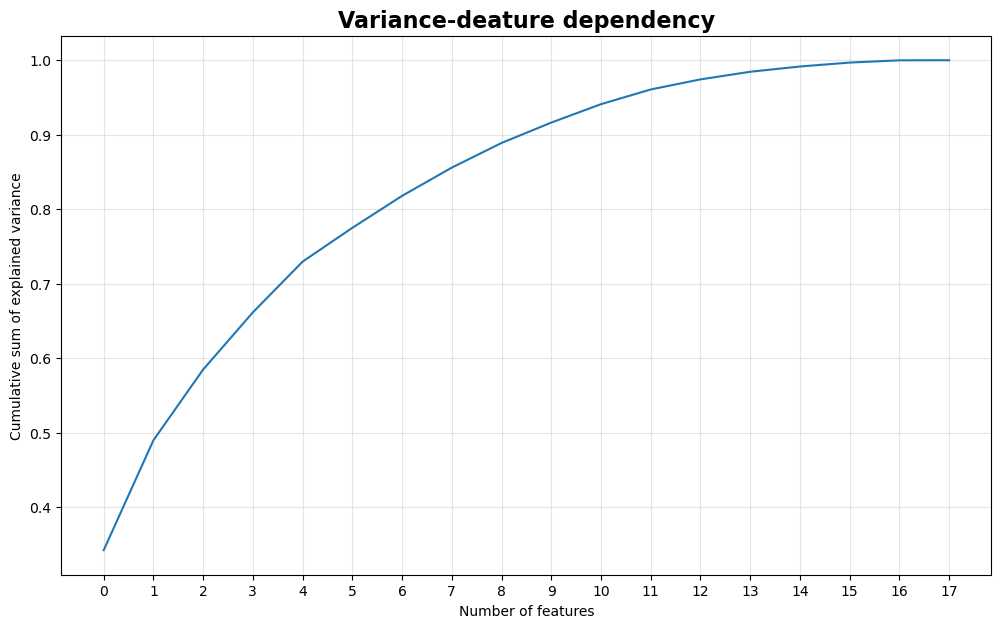

In [195]:
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12,7), dpi=100)
plt.plot(cumsum_variance)
plt.xticks(np.arange(len(regression_df_features.columns)))
plt.ylabel('Cumulative sum of explained variance')
plt.xlabel('Number of features')
plt.title('Variance-deature dependency', fontdict={'fontsize': 16, 'weight': 'bold'})
plt.show()

**<h3>**With the help of correlation matrix and PCA we can say that there are a couple of features that highly correlated with other features, which is not good from statistical point of view, so we're going to remove certain features from the dataset**</h3>**

**<h3>**We also saw that all the features contribte to the target variable relatively the same**</h3>**



In [196]:
regression_df = cleaned_df.copy()
regression_df = regression_df.drop(['Country', 'under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)
num_of_observations_per_year = regression_df.groupby('Year')['Life expectancy'].count()
num_of_observations_per_year

Year
2000    183
2001    183
2002    183
2003    183
2004    183
2005    183
2006    183
2007    183
2008    183
2009    183
2010    183
2011    183
2012    183
2013    193
2014    183
2015    183
Name: Life expectancy, dtype: int64

**<h3>**Since we've done proper cleaning and outliers handling, we have 183 observations per year (except 2013)**<h3>**

In [ ]:
# Group DataFrames by years
regression_dfs_by_year = {year: df for year, df in regression_df.groupby('Year')}

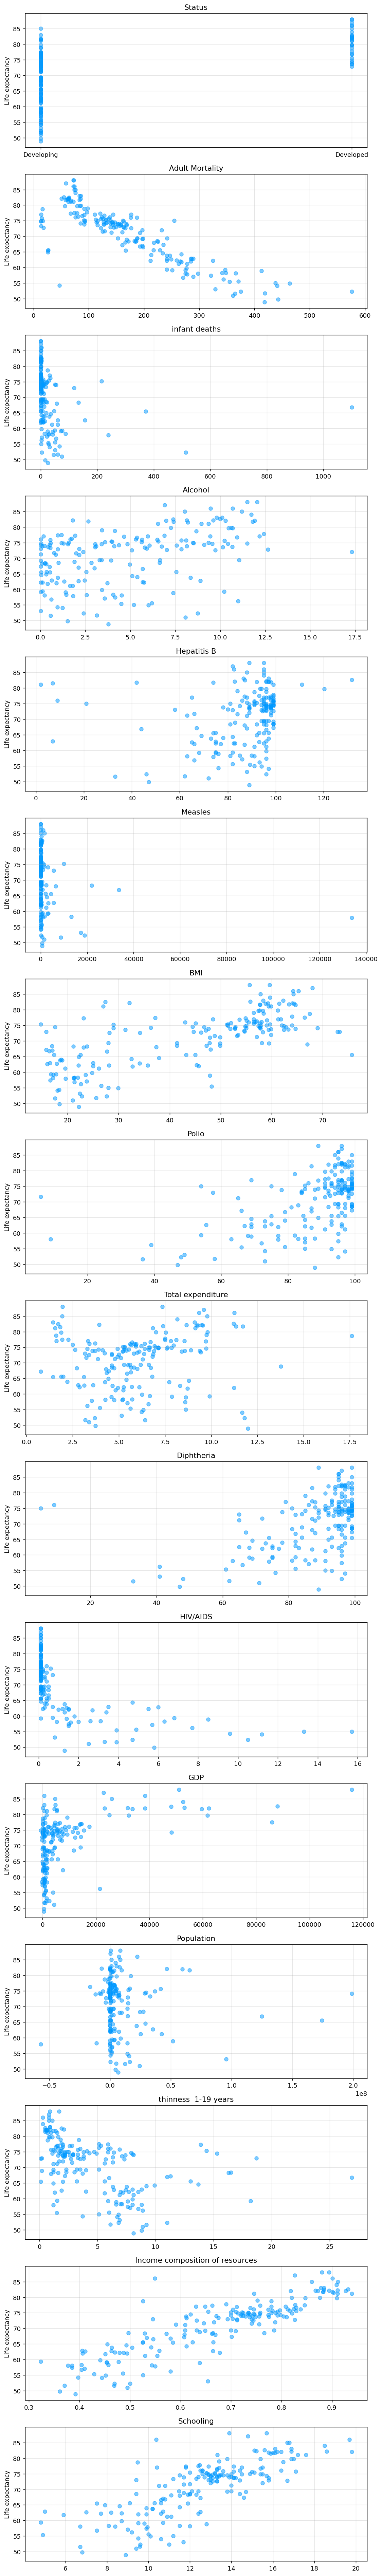

In [199]:
regression_features = regression_df.columns.drop(['Year','Life expectancy'])
fig, axes = plt.subplots(len(regression_features), figsize=(10, 75), dpi=130)

for col_num, col_name in enumerate(regression_features):

    axes[col_num].scatter(regression_dfs_by_year[2011][col_name], regression_dfs_by_year[2011]['Life expectancy'], alpha=0.5, color=(0,0.6,1))
    axes[col_num].set_title(col_name)
    axes[col_num].set_label(col_name)
    axes[col_num].set_ylabel('Life expectancy')



**<h3>**Importing statsmodels' Linear Regression for look at the dependencies:**</h3>**


In [200]:
from statsmodels.api import OLS

linreg_results = {}

for year, df in regression_dfs_by_year.items():
    feature_matrix = df[df.columns[4:]]
    target = df['Life expectancy']

    linreg_statsmodels = OLS(target, feature_matrix).fit()
    linreg_results[year] = linreg_statsmodels



In [201]:
for year in linreg_results.keys():
    print(f'for {year} R^2 is:\n{linreg_results[year].rsquared}')
    print('-'*18)
    print('\n')

for 2000 R^2 is:
0.990875319284776
------------------


for 2001 R^2 is:
0.9919988366358622
------------------


for 2002 R^2 is:
0.9917812899807618
------------------


for 2003 R^2 is:
0.9901607666615743
------------------


for 2004 R^2 is:
0.9905338771615427
------------------


for 2005 R^2 is:
0.9908115043519786
------------------


for 2006 R^2 is:
0.9934373907833626
------------------


for 2007 R^2 is:
0.9928163822296502
------------------


for 2008 R^2 is:
0.9934148825396338
------------------


for 2009 R^2 is:
0.992359218217514
------------------


for 2010 R^2 is:
0.9932923443392921
------------------


for 2011 R^2 is:
0.9939908371908248
------------------


for 2012 R^2 is:
0.9945733693078616
------------------


for 2013 R^2 is:
0.9951436551821183
------------------


for 2014 R^2 is:
0.9944387682347149
------------------


for 2015 R^2 is:
0.9957040717621176
------------------




**<h4>**In OLS summary we have coefficients for every feature and corresponding p value which basically inditcates the "probability" of these coefficinets being not statistically significant, so for each year we look at the feature whose coefficients are significant enough (p value < 0.05)**<h4>**

In [203]:
for year in linreg_results.keys():
    print(f"{year}'s relevant feature (corresponding p values) are: \n\n{linreg_results[year].pvalues[linreg_results[year].pvalues<0.05]}")
    print('-'*37)
    print('\n\n\n')

2000's relevant feature (corresponding p values) are: 

Adult Mortality                    5.374679e-03
Hepatitis B                        6.380120e-08
BMI                                3.589190e-06
Polio                              1.525111e-03
HIV/AIDS                           5.592854e-11
thinness  1-19 years               9.048402e-07
Income composition of resources    3.458831e-03
Schooling                          7.712007e-04
dtype: float64
-------------------------------------




2001's relevant feature (corresponding p values) are: 

infant deaths                      3.458196e-02
Hepatitis B                        4.935067e-09
Measles                            1.296442e-02
BMI                                1.647169e-04
Total expenditure                  6.172172e-03
HIV/AIDS                           4.917128e-09
Population                         5.366829e-03
thinness  1-19 years               5.818485e-06
Income composition of resources    3.027729e-02
Schooling      

**<h2>**Multivariate Time Series Analysis**</h2>**

<br><br>
**<h4>**As 'Status' column is not informationally significant to our time serieses because it is a basically a constant we can drop this column**<h4>**

In [204]:
tsa_df = cleaned_df.copy()
tsa_df = tsa_df.sort_values(by=['Country', 'Year'])
tsa_df = tsa_df.drop('Status', axis=1)
tsa_df = tsa_df.drop(['under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)

num_of_observations_per_country = tsa_df.groupby('Country')['Life expectancy'].count()
relevant_countries = num_of_observations_per_country[num_of_observations_per_country.sort_values(ascending=True)>10]


In [208]:
tsa_dfs_by_country = {country: df for country, df in tsa_df.groupby('Country')}
feature_columns = tsa_df.columns.drop(['Country', 'Year', 'Life expectancy'])
target_column = 'Life expectancy'


In [101]:
from scipy.stats import yeojohnson
from scipy.ndimage import shift

def check_stationarity(time_series: pd.Series) -> tuple[str, str]:

    adf_p_value = adfuller(time_series)[1]
    kpss_p_value = kpss(time_series, nlags='auto')[1]
    
    adf_result = "Stationary" if adf_p_value < 0.05 else "Not stationary"
    kpss_result = "Not stationary" if kpss_p_value < 0.05 else "Stationary"
    
    return adf_result, kpss_result

def make_stationary(time_series: pd.Series) -> pd.Series:

    """
    NOTE:
    Some of the columns might contain cxonstant values,
    and kpss test returns an error if an input is just a series of 
    constant values, thus here we test if the time series is constant.
    """
    if time_series.max() == time_series.min():
        return time_series


    adf_result, kpss_result = check_stationarity(time_series)
    
    if adf_result == "Stationary" and kpss_result == "Stationary":
        return time_series
    
    elif adf_result == "Not stationary" and kpss_result == "Stationary":
        # Применяем преобразование Yeo-Johnson
        time_series = yeojohnson(time_series)[0]
        time_series = pd.Series(time_series)
    
    elif adf_result == "Stationary" and kpss_result == "Not stationary":
        # Берем первую разность
        time_series = time_series.diff().dropna()

        adf_result, kpss_result = check_stationarity(time_series)

        if kpss_result == "Not stationary":

            time_series = time_series.diff().dropna()

    
    # Повторная проверка
    adf_result, kpss_result = check_stationarity(time_series)
    
    if adf_result == "Not stationary" or kpss_result == "Not stationary":
        return "Cannot be made stationary"
    
    return time_series



    

In [209]:
non_stationary_ts_per_country = {}
non_stationary_count = 0



for keys, values in tsa_dfs_by_country.items():
    
    country_df = values[feature_columns]
    non_stationary_count = 0

    for column in country_df.columns:
        if type(make_stationary(country_df[column])) == str:
            non_stationary_count+=1

    non_stationary_ts_per_country[keys] = non_stationary_count

        



C:\Users\user\AppData\Local\Temp\ipykernel_18944\3037478181.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(time_series, nlags='auto')[1]
C:\Users\user\AppData\Local\Temp\ipykernel_18944\3037478181.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(time_series, nlags='auto')[1]
C:\Users\user\AppData\Local\Temp\ipykernel_18944\3037478181.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(time_series, nlags='auto')[1]
C:\Users\user\AppData\Local\Temp\ipykernel_18944\3037478181.py:7: InterpolationWarning: The test statistic is outside of the range of p-values av

<Axes: >

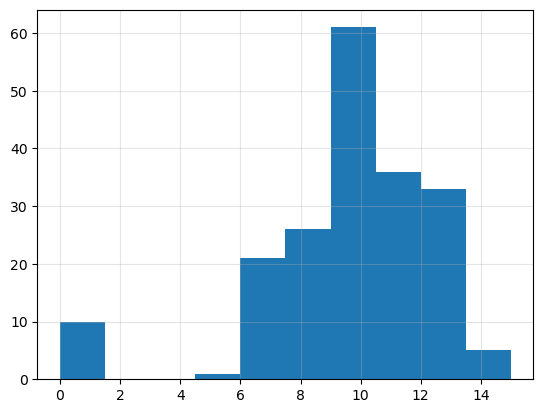

In [210]:
non_stationary_ts_per_country = pd.Series(non_stationary_ts_per_country)
non_stationary_ts_per_country.hist()

**<h4>**As we can see, there is on average a significant amount of time series that cannot be made stationary through traditional methods. Thus, VARIMA model wouldn't be the best choice in that case.<br><br>Instead boosting alorithms are going ot be used as they appear to be more robust to outliers and othger preventive factors in our dataset**<h4>**

In [211]:
status_feature_count = {}

for country in df_per_country.keys():

    if len(df_per_country[country]['Status'].value_counts())>1:
        status_feature_count[country] = len(df_per_country[country]['Status'].value_counts())


status_feature_count


{}

**<h4>**We see that for each country 'Status' column is not informationally significant as it doesn't bring any variety, so we can easily drop it from the TS dataset**<h4>**

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error

def create_features(df: pd.DataFrame, target_column, lags: int) -> pd.DataFrame:
    """
    Create lag feature as we assume that the previous values of TS 
    have certain impact on y_t
    """

    df = df.copy()
    df = df.drop('Country', axis=1)

    for lag in range(lags):

        df[f"lag_{lag+1}"] = df[target_column].shift(lag+1)

    df.dropna(inplace=True)

    return df

def train_xgboost_for_country(df, target_column):

    df = create_features(df, target_column, lags=3)
    
    X = df.drop(columns=[target_column])
    y = df[target_column]

    tscv = TimeSeriesSplit(n_splits=3)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)

    preds = model.predict(X_test)
    RMSE = root_mean_squared_error(y_test, preds)


    return model, RMSE

def train_xgboost_for_all_countries(data_dict, target_column):

    results = {}
    for country, df in data_dict.items():
        model, rmse = train_xgboost_for_country(df, target_column)
        results[country] = {"model": model, "rmse": rmse}
        print(f"{country}: RMSE = {rmse:.4f}")
    return results


In [214]:

results = train_xgboost_for_all_countries(tsa_dfs_by_country, target_column=target_column)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Country: object

In [ ]:
for keys, values in tsa_dfs_by_country.items():
    

{'Afghanistan':         Country  Year  Life expectancy  Adult Mortality  infant deaths  \
 0   Afghanistan  2000             54.8            321.0           88.0   
 1   Afghanistan  2001             55.3            316.0           88.0   
 2   Afghanistan  2002             56.2            284.0           88.0   
 3   Afghanistan  2003             56.7            295.0           87.0   
 4   Afghanistan  2004             57.0            293.0           87.0   
 5   Afghanistan  2005             57.3            291.0           85.0   
 6   Afghanistan  2006             57.3            295.0           84.0   
 7   Afghanistan  2007             57.5            295.0           82.0   
 8   Afghanistan  2008             58.1            287.0           80.0   
 9   Afghanistan  2009             58.6            281.0           77.0   
 10  Afghanistan  2010             58.8            279.0           74.0   
 11  Afghanistan  2011             59.2            275.0           71.0   
 12  Afgha

In [ ]:
tsa_dfs_by_country['Afghanistan']

,Country,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,Hepatitis B,Measles,BMI,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,Income composition of resources,Schooling
0,Afghanistan,2000,54.8,321.0,88.0,0.01,62.0,1794.0,12.2,24.0,8.20,24.0,0.1,114.560000,293756.0,18.5,0.338,5.5
1,Afghanistan,2001,55.3,316.0,88.0,0.01,63.0,1794.0,12.6,35.0,7.80,33.0,0.1,117.496980,2966463.0,18.5,0.340,5.9
2,Afghanistan,2002,56.2,284.0,88.0,0.01,64.0,2486.0,13.0,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,0.341,6.2
3,Afghanistan,2003,56.7,295.0,87.0,0.01,65.0,798.0,13.4,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,0.373,6.5
4,Afghanistan,2004,57.0,293.0,87.0,0.02,67.0,466.0,13.8,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,0.381,6.8
5,Afghanistan,2005,57.3,291.0,85.0,0.02,66.0,1296.0,14.2,58.0,8.70,58.0,0.1,25.294130,257798.0,19.3,0.396,7.9
6,Afghanistan,2006,57.3,295.0,84.0,0.03,64.0,1990.0,14.7,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,0.405,8.1
7,Afghanistan,2007,57.5,295.0,82.0,0.02,63.0,1141.0,15.2,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,0.415,8.4
8,Afghanistan,2008,58.1,287.0,80.0,0.03,64.0,1599.0,15.7,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,0.433,8.7
9,Afghanistan,2009,58.6,281.0,77.0,0.01,63.0,2861.0,16.2,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,0.434,8.9
